# **Install**

In [ ]:
!pip install torchmetrics

# **Imports 📢**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Transform

In [30]:
transform_train = T.Compose([T.RandomCrop(32, padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                         std=(0.2023, 0.1994, 0.2010))])

transform_test = T.Compose([T.ToTensor(),
                            T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                        std=(0.2023, 0.1994, 0.2010))])

## CIFAR Dataset

In [31]:
train_set = CIFAR10(root='./cifar10', train=True,
                    download=True,
                    transform=transform_train)

test_set = CIFAR10(root='./cifar10', train=False,
                   download=True,
                   transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
train_set.data.shape

(50000, 32, 32, 3)

In [15]:
torch.FloatTensor(train_set.data/255.).mean(dim=[0, 1, 2])

tensor([0.4914, 0.4822, 0.4465])

In [16]:
torch.FloatTensor(train_set.data/255.).std(dim=[0, 1, 2])

tensor([0.2470, 0.2435, 0.2616])

In [17]:
torch.FloatTensor(test_set.data/255.).mean(dim=[0, 1, 2])

tensor([0.4942, 0.4851, 0.4504])

In [18]:
torch.FloatTensor(test_set.data/255.).std(dim=[0, 1, 2])

tensor([0.2467, 0.2429, 0.2616])

In [20]:
train_set[15][0]

tensor([[[-3.1611e-05, -3.1611e-05, -2.3857e-05,  ..., -4.3242e-05,
          -4.3242e-05, -3.9365e-05],
         [-1.2226e-05,  9.0974e-06,  1.3434e-06,  ..., -3.3549e-05,
          -3.3549e-05, -3.1611e-05],
         [ 6.3375e-05,  8.2760e-05,  5.9498e-05,  ..., -2.7734e-05,
          -2.7734e-05, -2.5796e-05],
         ...,
         [-2.4291e-04, -2.4291e-04, -2.4291e-04,  ..., -2.4291e-04,
          -2.4291e-04, -2.4291e-04],
         [-2.4291e-04, -2.4291e-04, -2.4291e-04,  ..., -2.4291e-04,
          -2.4291e-04, -2.4291e-04],
         [-2.4291e-04, -2.4291e-04, -2.4291e-04,  ..., -2.4291e-04,
          -2.4291e-04, -2.4291e-04]],

        [[ 1.0824e+00,  1.0234e+00,  1.0038e+00,  ...,  9.8411e-01,
           9.8411e-01,  1.0234e+00],
         [ 1.1611e+00,  1.0431e+00,  7.6777e-01,  ...,  1.0824e+00,
           1.0824e+00,  1.1021e+00],
         [ 1.2791e+00,  1.1021e+00,  8.8578e-01,  ...,  1.1611e+00,
           1.1414e+00,  1.1808e+00],
         ...,
         [-2.4183e+00, -2

In [21]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [22]:
train_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [23]:
len(train_set)

50000

## DataLoader

In [32]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(train_set, batch_size=64, shuffle=False)

In [33]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([7, 8, 4, 5, 8, 4, 1, 9, 2, 6, 9, 0, 8, 4, 8, 6, 7, 9, 4, 5, 4, 9, 3, 7,
        0, 6, 7, 8, 5, 7, 0, 2, 0, 7, 3, 7, 4, 8, 0, 1, 0, 6, 7, 8, 2, 5, 2, 4,
        3, 7, 9, 5, 8, 6, 9, 5, 2, 4, 0, 0, 7, 6, 1, 8])


## Visualize

In [28]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

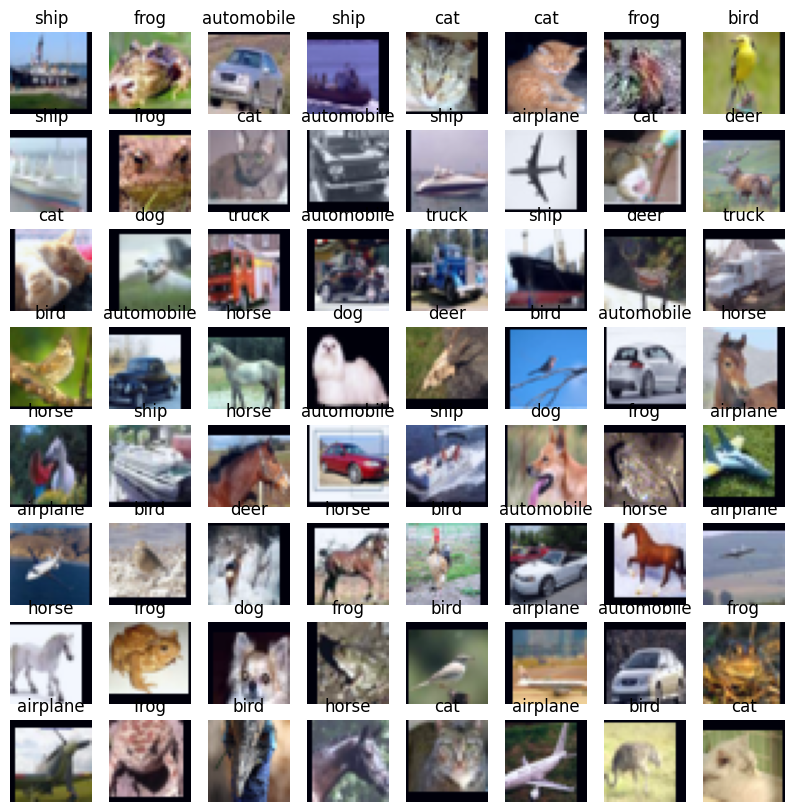

In [34]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

In [35]:
def CNN():
  network = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU(),

                          nn.Conv2d(64, 64, 3, padding=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU(),

                          nn.MaxPool2d(2, 2), # BSx64x16x16

                          nn.Conv2d(64, 128, 3, padding=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),

                          nn.Conv2d(128, 128, 3, padding=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),

                          nn.MaxPool2d(2,2), # 8x8

                          nn.Conv2d(128, 256, 3, padding=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),

                          nn.Conv2d(256, 256, 3, padding=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),
                          # BSx256x8x8 -> BSx256x1x1
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # BS1x1

                          nn.Flatten(), # BSx256
                          nn.Linear(256, 10)
                      )

  return network



In [38]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [39]:
def CNN():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          conv3x3_bn_af(64, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          conv3x3_bn_af(128, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          conv3x3_bn_af(256, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          conv3x3_bn_af(512, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [40]:
nn.AvgPool2d(4, 1)

AvgPool2d(kernel_size=4, stride=1, padding=0)

In [41]:
model = CNN()

In [42]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [43]:
num_params(model)

4.694346

# **Device ⚙️**

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [45]:
device

'cuda'

# **Loss & Optimizer ⚖️**

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Utils 🧰**

In [47]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [61]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=10).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [57]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=10).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [62]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3254, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [63]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [64]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 50/50 [00:01<00:00, 37.24batch/s, accuracy=56.8, loss=1.22]


## Step 3: select best lr

Train all data for one epoch

In [65]:
num_epochs = 2
for lr in [0.1, 0.01]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 1: 100%|██████████| 782/782 [00:43<00:00, 17.87batch/s, accuracy=72.7, loss=0.783]



LR=0.01


Epoch 1: 100%|██████████| 782/782 [00:43<00:00, 17.81batch/s, accuracy=65.3, loss=0.975]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [66]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.08, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:43<00:00, 18.09batch/s, accuracy=82.9, loss=0.494]



LR=0.08, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:44<00:00, 17.51batch/s, accuracy=83.4, loss=0.485]



LR=0.08, WD=0.0


Epoch 4: 100%|██████████| 782/782 [00:44<00:00, 17.43batch/s, accuracy=83, loss=0.491]



LR=0.09, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:46<00:00, 16.74batch/s, accuracy=83, loss=0.492]



LR=0.09, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:45<00:00, 17.24batch/s, accuracy=83.2, loss=0.485]



LR=0.09, WD=0.0


Epoch 4: 100%|██████████| 782/782 [00:45<00:00, 17.15batch/s, accuracy=82.9, loss=0.49]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:45<00:00, 17.37batch/s, accuracy=82.9, loss=0.493]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 782/782 [00:45<00:00, 17.23batch/s, accuracy=83.1, loss=0.489]



LR=0.1, WD=0.0


Epoch 1:  54%|█████▍    | 421/782 [00:24<00:20, 17.29batch/s, accuracy=69.9, loss=0.849]


KeyboardInterrupt: 

## Step 5: train more epochs

In [67]:
model = CNN().to(device)

In [68]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [69]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [70]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:43<00:00, 17.99batch/s, accuracy=53.5, loss=1.27]


Valid: Loss = 3.735, Acc = 0.2886



Epoch 1: 100%|██████████| 782/782 [00:44<00:00, 17.51batch/s, accuracy=72.6, loss=0.785]


Valid: Loss = 0.9366, Acc = 0.691



Epoch 2: 100%|██████████| 782/782 [00:44<00:00, 17.67batch/s, accuracy=77.9, loss=0.636]


Valid: Loss = 0.772, Acc = 0.7331



Epoch 3: 100%|██████████| 782/782 [00:43<00:00, 17.84batch/s, accuracy=80.9, loss=0.546]


Valid: Loss = 0.8553, Acc = 0.7195



Epoch 4: 100%|██████████| 782/782 [00:44<00:00, 17.69batch/s, accuracy=82.9, loss=0.491]


Valid: Loss = 0.5527, Acc = 0.8098



Epoch 5: 100%|██████████| 782/782 [00:43<00:00, 17.91batch/s, accuracy=84.5, loss=0.446]


Valid: Loss = 1.014, Acc = 0.6809



Epoch 6: 100%|██████████| 782/782 [00:43<00:00, 18.01batch/s, accuracy=85.8, loss=0.407]


Valid: Loss = 0.6186, Acc = 0.7883



Epoch 7: 100%|██████████| 782/782 [00:44<00:00, 17.76batch/s, accuracy=86.9, loss=0.377]


Valid: Loss = 0.7556, Acc = 0.7665



Epoch 8: 100%|██████████| 782/782 [00:43<00:00, 17.92batch/s, accuracy=87.6, loss=0.352]


Valid: Loss = 0.5138, Acc = 0.8167



Epoch 9: 100%|██████████| 782/782 [00:44<00:00, 17.39batch/s, accuracy=88.7, loss=0.324]


Valid: Loss = 0.3328, Acc = 0.884



Epoch 10: 100%|██████████| 782/782 [00:44<00:00, 17.60batch/s, accuracy=89.5, loss=0.303]


Valid: Loss = 0.311, Acc = 0.8943



Epoch 11: 100%|██████████| 782/782 [00:43<00:00, 17.80batch/s, accuracy=90.2, loss=0.282]


Valid: Loss = 0.5661, Acc = 0.8179



Epoch 12: 100%|██████████| 782/782 [00:44<00:00, 17.62batch/s, accuracy=90.7, loss=0.267]


Valid: Loss = 0.3394, Acc = 0.8796



Epoch 13: 100%|██████████| 782/782 [00:43<00:00, 17.90batch/s, accuracy=91.3, loss=0.25]


Valid: Loss = 0.301, Acc = 0.8956



Epoch 14: 100%|██████████| 782/782 [00:44<00:00, 17.56batch/s, accuracy=91.8, loss=0.236]


Valid: Loss = 0.3925, Acc = 0.8718



# **Plot**

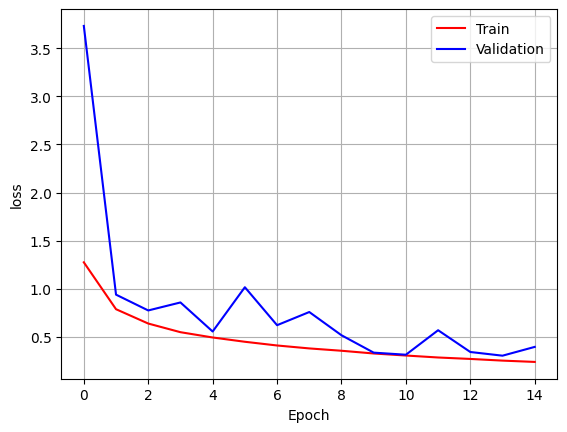

In [71]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

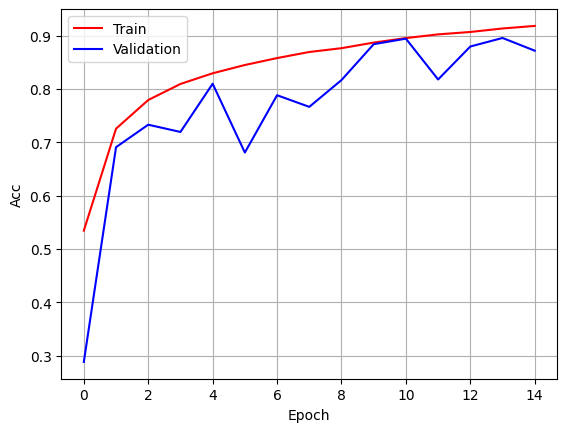

In [72]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [73]:
model = CNN().to(device)
lr = 0.08
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:44<00:00, 17.63batch/s, accuracy=55.1, loss=1.24]


Valid: Loss = 1.115, Acc = 0.6122



Epoch 1: 100%|██████████| 782/782 [00:43<00:00, 18.16batch/s, accuracy=72.8, loss=0.773]


Valid: Loss = 1.127, Acc = 0.6266



Epoch 2: 100%|██████████| 782/782 [00:43<00:00, 17.87batch/s, accuracy=78.1, loss=0.633]


Valid: Loss = 1.136, Acc = 0.6308



Epoch 3: 100%|██████████| 782/782 [00:43<00:00, 18.07batch/s, accuracy=81, loss=0.549]


Valid: Loss = 0.7932, Acc = 0.7298



Epoch 4: 100%|██████████| 782/782 [00:43<00:00, 17.81batch/s, accuracy=83, loss=0.489]


Valid: Loss = 0.5752, Acc = 0.7972



Epoch 5: 100%|██████████| 782/782 [00:42<00:00, 18.28batch/s, accuracy=84.6, loss=0.444]


Valid: Loss = 0.5503, Acc = 0.8139



Epoch 6: 100%|██████████| 782/782 [00:43<00:00, 17.98batch/s, accuracy=85.9, loss=0.403]


Valid: Loss = 0.6416, Acc = 0.7794



Epoch 7: 100%|██████████| 782/782 [00:43<00:00, 18.14batch/s, accuracy=87.1, loss=0.374]


Valid: Loss = 0.4825, Acc = 0.8376



Epoch 8: 100%|██████████| 782/782 [00:43<00:00, 17.81batch/s, accuracy=87.9, loss=0.348]


Valid: Loss = 0.4991, Acc = 0.8297



Epoch 9: 100%|██████████| 782/782 [00:43<00:00, 18.17batch/s, accuracy=88.8, loss=0.321]


Valid: Loss = 0.5362, Acc = 0.8228



Epoch 10: 100%|██████████| 782/782 [00:43<00:00, 17.84batch/s, accuracy=89.4, loss=0.303]


Valid: Loss = 0.683, Acc = 0.7782



Epoch 11: 100%|██████████| 782/782 [00:43<00:00, 18.17batch/s, accuracy=90, loss=0.283]


Valid: Loss = 0.3027, Acc = 0.8945



Epoch 12: 100%|██████████| 782/782 [00:43<00:00, 17.85batch/s, accuracy=90.5, loss=0.269]


Valid: Loss = 0.2618, Acc = 0.9093



Epoch 13: 100%|██████████| 782/782 [00:43<00:00, 18.02batch/s, accuracy=91.3, loss=0.248]


Valid: Loss = 0.2786, Acc = 0.9047



Epoch 14: 100%|██████████| 782/782 [00:43<00:00, 17.86batch/s, accuracy=91.5, loss=0.241]


Valid: Loss = 0.3762, Acc = 0.8692



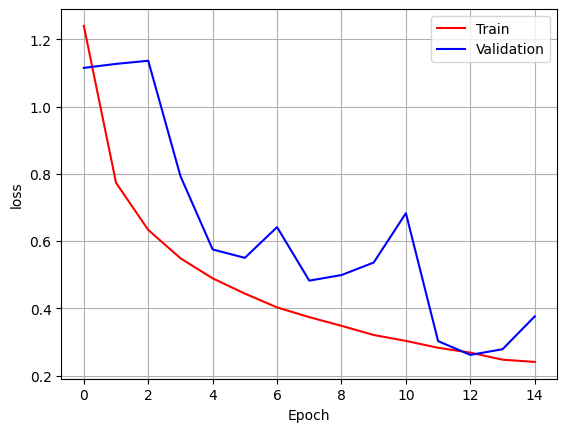

In [74]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

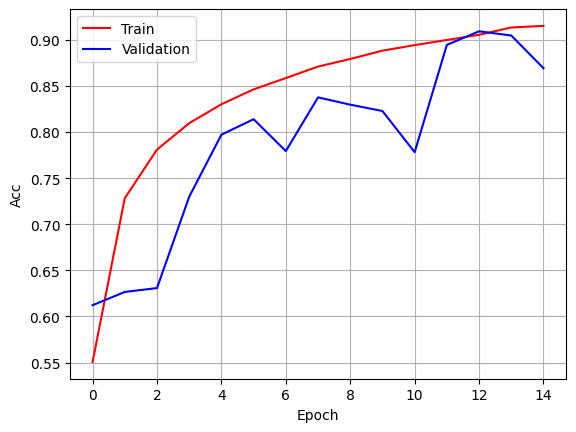

In [75]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [79]:
model = CNN().to(device)
lr = 0.09
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0
num_epochs = 18

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:43<00:00, 17.99batch/s, accuracy=54.3, loss=1.26]


Valid: Loss = 1.401, Acc = 0.5325



Epoch 1: 100%|██████████| 782/782 [00:43<00:00, 17.80batch/s, accuracy=72.9, loss=0.771]


Valid: Loss = 0.8949, Acc = 0.6889



Epoch 2: 100%|██████████| 782/782 [00:43<00:00, 17.89batch/s, accuracy=78, loss=0.628]


Valid: Loss = 1.568, Acc = 0.5873



Epoch 3: 100%|██████████| 782/782 [00:43<00:00, 17.99batch/s, accuracy=81.1, loss=0.543]


Valid: Loss = 0.8878, Acc = 0.6959



Epoch 4: 100%|██████████| 782/782 [00:43<00:00, 17.95batch/s, accuracy=83.1, loss=0.484]


Valid: Loss = 0.5982, Acc = 0.793



Epoch 5: 100%|██████████| 782/782 [00:43<00:00, 18.06batch/s, accuracy=84.8, loss=0.441]


Valid: Loss = 0.7333, Acc = 0.7685



Epoch 6: 100%|██████████| 782/782 [00:44<00:00, 17.75batch/s, accuracy=85.9, loss=0.406]


Valid: Loss = 1.41, Acc = 0.5615



Epoch 7: 100%|██████████| 782/782 [00:43<00:00, 17.96batch/s, accuracy=87, loss=0.375]


Valid: Loss = 0.4733, Acc = 0.8427



Epoch 8: 100%|██████████| 782/782 [00:45<00:00, 17.35batch/s, accuracy=88.1, loss=0.342]


Valid: Loss = 0.7501, Acc = 0.7651



Epoch 9: 100%|██████████| 782/782 [00:44<00:00, 17.42batch/s, accuracy=89, loss=0.319]


Valid: Loss = 0.4992, Acc = 0.8348



Epoch 10: 100%|██████████| 782/782 [00:45<00:00, 17.37batch/s, accuracy=89.5, loss=0.297]


Valid: Loss = 0.2525, Acc = 0.9107



Epoch 11: 100%|██████████| 782/782 [00:44<00:00, 17.39batch/s, accuracy=90.3, loss=0.277]


Valid: Loss = 0.3621, Acc = 0.8755



Epoch 12: 100%|██████████| 782/782 [00:45<00:00, 17.37batch/s, accuracy=91, loss=0.258]


Valid: Loss = 0.2989, Acc = 0.896



Epoch 13: 100%|██████████| 782/782 [00:44<00:00, 17.46batch/s, accuracy=91.3, loss=0.245]


Valid: Loss = 0.4589, Acc = 0.8483



Epoch 14: 100%|██████████| 782/782 [00:45<00:00, 17.30batch/s, accuracy=92, loss=0.231]


Valid: Loss = 0.3446, Acc = 0.8797



Epoch 15: 100%|██████████| 782/782 [00:44<00:00, 17.40batch/s, accuracy=92.4, loss=0.217]


Valid: Loss = 0.4364, Acc = 0.861



Epoch 16: 100%|██████████| 782/782 [00:44<00:00, 17.73batch/s, accuracy=93, loss=0.202]


Valid: Loss = 0.3512, Acc = 0.8824



Epoch 17: 100%|██████████| 782/782 [00:44<00:00, 17.49batch/s, accuracy=93.4, loss=0.188]


Valid: Loss = 0.2562, Acc = 0.9114



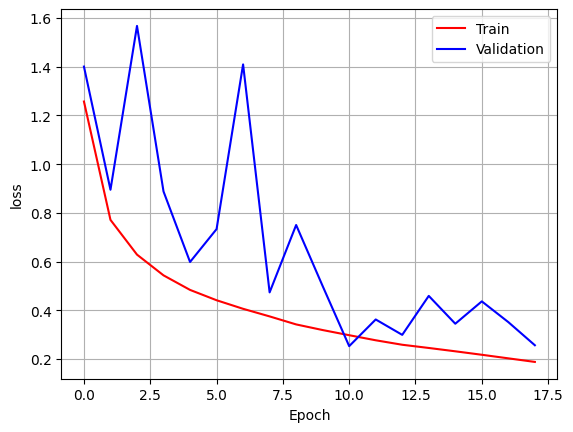

In [80]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

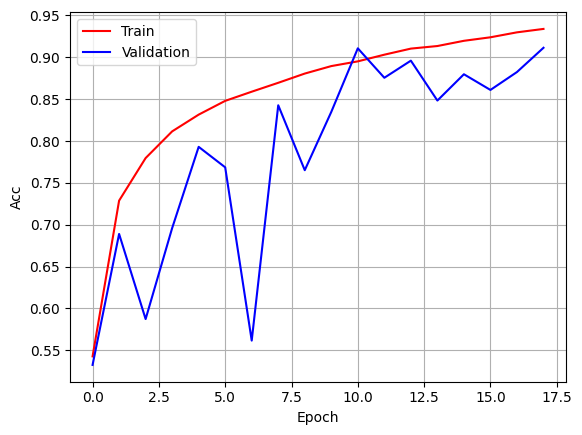

In [81]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [82]:
model = CNN().to(device)
lr = 0.09
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0
num_epochs = 25

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:45<00:00, 17.10batch/s, accuracy=54.4, loss=1.25]


Valid: Loss = 1.622, Acc = 0.4941



Epoch 1: 100%|██████████| 782/782 [00:45<00:00, 17.32batch/s, accuracy=72.6, loss=0.781]


Valid: Loss = 1.389, Acc = 0.5684



Epoch 2: 100%|██████████| 782/782 [00:44<00:00, 17.45batch/s, accuracy=78, loss=0.636]


Valid: Loss = 2.308, Acc = 0.4423



Epoch 3: 100%|██████████| 782/782 [00:46<00:00, 16.84batch/s, accuracy=81.1, loss=0.549]


Valid: Loss = 0.6533, Acc = 0.7779



Epoch 4: 100%|██████████| 782/782 [00:44<00:00, 17.61batch/s, accuracy=83.3, loss=0.482]


Valid: Loss = 0.9378, Acc = 0.7164



Epoch 5: 100%|██████████| 782/782 [00:44<00:00, 17.57batch/s, accuracy=84.8, loss=0.44]


Valid: Loss = 0.7946, Acc = 0.7442



Epoch 6: 100%|██████████| 782/782 [00:47<00:00, 16.57batch/s, accuracy=86.1, loss=0.402]


Valid: Loss = 0.5088, Acc = 0.822



Epoch 7: 100%|██████████| 782/782 [00:46<00:00, 16.83batch/s, accuracy=87.3, loss=0.367]


Valid: Loss = 0.8995, Acc = 0.7313



Epoch 8: 100%|██████████| 782/782 [00:45<00:00, 17.15batch/s, accuracy=88.1, loss=0.345]


Valid: Loss = 0.6627, Acc = 0.7851



Epoch 9: 100%|██████████| 782/782 [00:46<00:00, 16.95batch/s, accuracy=88.9, loss=0.32]


Valid: Loss = 0.6962, Acc = 0.7802



Epoch 10: 100%|██████████| 782/782 [00:44<00:00, 17.62batch/s, accuracy=89.7, loss=0.297]


Valid: Loss = 0.364, Acc = 0.8758



Epoch 11: 100%|██████████| 782/782 [00:45<00:00, 17.31batch/s, accuracy=90.3, loss=0.277]


Valid: Loss = 0.3278, Acc = 0.8843



Epoch 12: 100%|██████████| 782/782 [00:44<00:00, 17.49batch/s, accuracy=90.9, loss=0.263]


Valid: Loss = 0.3379, Acc = 0.8826



Epoch 13: 100%|██████████| 782/782 [00:44<00:00, 17.64batch/s, accuracy=91.4, loss=0.247]


Valid: Loss = 0.2471, Acc = 0.9132



Epoch 14: 100%|██████████| 782/782 [00:44<00:00, 17.45batch/s, accuracy=91.9, loss=0.231]


Valid: Loss = 0.3856, Acc = 0.8677



Epoch 15: 100%|██████████| 782/782 [00:45<00:00, 17.37batch/s, accuracy=92.4, loss=0.216]


Valid: Loss = 0.261, Acc = 0.9092



Epoch 16: 100%|██████████| 782/782 [00:44<00:00, 17.54batch/s, accuracy=92.8, loss=0.202]


Valid: Loss = 0.292, Acc = 0.9015



Epoch 17: 100%|██████████| 782/782 [00:45<00:00, 17.24batch/s, accuracy=93.4, loss=0.19]


Valid: Loss = 0.1987, Acc = 0.9288



Epoch 18: 100%|██████████| 782/782 [00:45<00:00, 17.13batch/s, accuracy=93.5, loss=0.184]


Valid: Loss = 0.2176, Acc = 0.9235



Epoch 19: 100%|██████████| 782/782 [00:44<00:00, 17.69batch/s, accuracy=94, loss=0.171]


Valid: Loss = 0.1559, Acc = 0.9457



Epoch 20: 100%|██████████| 782/782 [00:44<00:00, 17.72batch/s, accuracy=94.2, loss=0.164]


Valid: Loss = 0.5639, Acc = 0.8544



Epoch 21: 100%|██████████| 782/782 [00:43<00:00, 17.93batch/s, accuracy=94.7, loss=0.153]


Valid: Loss = 0.4704, Acc = 0.859



Epoch 22: 100%|██████████| 782/782 [00:43<00:00, 17.81batch/s, accuracy=94.8, loss=0.147]


Valid: Loss = 0.1439, Acc = 0.9499



Epoch 23: 100%|██████████| 782/782 [00:44<00:00, 17.76batch/s, accuracy=95.1, loss=0.138]


Valid: Loss = 0.2041, Acc = 0.9259



Epoch 24: 100%|██████████| 782/782 [00:44<00:00, 17.68batch/s, accuracy=95.5, loss=0.128]


Valid: Loss = 0.3568, Acc = 0.8792



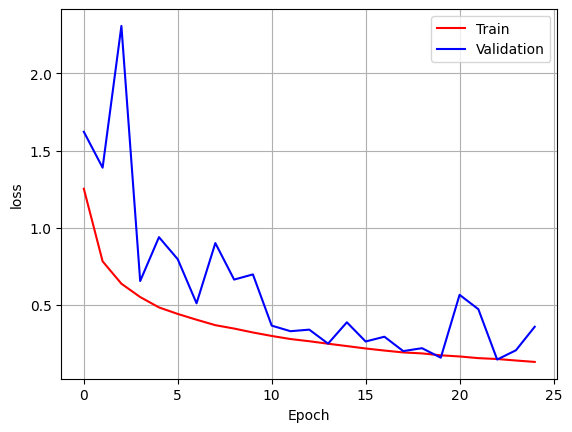

In [83]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

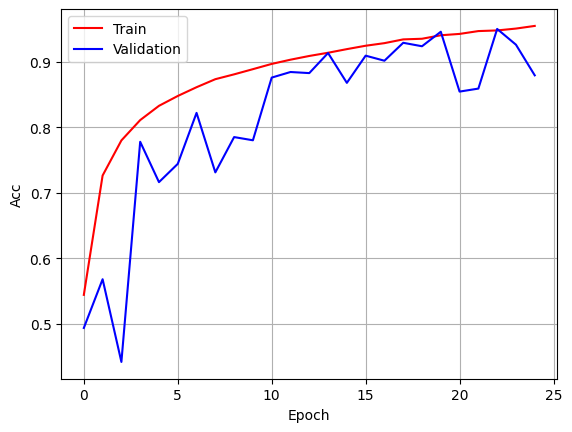

In [84]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()